<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<br>
<b> DM-47045-Investigate excess diaSources in DECam following DM-46678 </b><br>
Notebook comparing main with the updated sourceSelector configs in subtractImages <code>diffIm</code> (DM-46678). The updated configurations caused an excess number of diaSources in the HSC and DC2 datasets while decreasing the number of diaSources in DECam. <br> <br>

Contact author: Audrey Budlong <br>
Last verified to run: 19 November 2024 <br>
LSST Science Pipelines version: <code>w_2024_44</code> (with DM-46678 changes) and <code>d_2024_11_06</code> (without DM-46678 changes)<br>
Additional notes: run with a local ap_verfify run of <code>ap_verify_ci_hits2015</code> <br>

## Run details

Baseline run using <code>d_2024_44</code> and <code>d_2024_11_06</code>. <code>DM-46678</code> changes were merged on October 17th, 2024, and reverted in <code>DM-47384</code> on November 5th, 2024. For an updated run comparison, the pre-change version corresponds to the <code>w_2024_44</code> run and the post-change version corresponds to the <code>d_2024_11_18</code> November run. Changes refer to updating the subtractImages sourceSelector to <code>calib_psf_used</code>.

### Table of Contents

1. Main package imports
2. Configuring data access
3. APBD Source Comparison
4. Visualizing APDB Source Comparison
5. Source Comparison at Detector-Level
6. Plot of fluxes for main and DM-46678

### 1. Main package imports

In [1]:
import lsst.afw.display as afwDisplay
import lsst.geom as geom
import gc
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

from astropy.table import Table
from astropy.visualization import make_lupton_rgb
from astropy.wcs import WCS
from IPython.display import Image
from lsst.afw.image import MultibandExposure
from lsst.analysis.ap import apdb, nb_utils
from lsst.analysis.ap import plotImageSubtractionCutouts as plotISC
from lsst.daf.butler import Butler
from lsst.ip.diffim import AlardLuptonSubtractTask, AlardLuptonSubtractConfig
from sqlalchemy import select, func

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
plt.style.use('ggplot')
plt.rcParams['axes.facecolor'] = 'whitesmoke'

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

### 2. Configuring data access

In [2]:
repo_main = '/Users/audrey/Documents/LSST/code/ap_verify-runs/DECam/d_2024_11_18/repo/butler.yaml'
repo_dm46678 = '/Users/audrey/Documents/LSST/code/ap_verify-runs/DECam/w_2024_44/repo/butler.yaml'
collections = 'ap_verify-output'
instrument = 'DECam'
skymap = 'decam_rings_v1'

butler_main = Butler(repo_main, collections=collections)
butler_dm46678 = Butler(repo_dm46678, collections=collections)

dbType = 'sqlite'
dbName_main = '/Users/audrey/Documents/LSST/code/ap_verify-runs/DECam/d_2024_11_18/association.db'
dbName_dm46678 = '/Users/audrey/Documents/LSST/code/ap_verify-runs/DECam/w_2024_44/association.db'

reader_main = apdb.ApdbSqliteQuery(dbName_main, instrument=instrument)
reader_dm46678 = apdb.ApdbSqliteQuery(dbName_dm46678, instrument=instrument)

In [3]:
len(reader_main._tables), len(reader_dm46678._tables)

(6, 6)

In [4]:
main_run = {
    'repo': repo_main,
    'collections': collections,
    'instrument': instrument,
    'skymap': skymap,
    'butler': butler_main,
    'dbType': dbType,
    'dbName': dbName_main,
    'reader': reader_main
}

dm46678_run = {
    'repo': repo_dm46678,
    'collections': collections,
    'instrument': instrument,
    'skymap': skymap,
    'butler': butler_dm46678,
    'dbType': dbType,
    'dbName': dbName_dm46678,
    'reader': reader_dm46678
}

In [5]:
main_run['run_name'] = 'Without DM-46678 Changes'
dm46678_run['run_name'] = 'With DM-46678 Changes'

In [6]:
main_run['robjTable'] = main_run['reader'].load_objects()
main_run['rsrcTable'] = main_run['reader'].load_sources()

dm46678_run['robjTable'] = dm46678_run['reader'].load_objects()
dm46678_run['rsrcTable'] = dm46678_run['reader'].load_sources()

In [7]:
registry_main = butler_main.registry
registry_dm46678 = butler_dm46678.registry

datarefs_main = list(registry_main.queryDatasets('initial_pvi'))
datarefs_dm46678 = list(registry_dm46678.queryDatasets('initial_pvi'))

In [8]:
datarefs_main

[DatasetRef(DatasetType('initial_pvi', {band, instrument, day_obs, detector, physical_filter, visit}, ExposureF), {instrument: 'DECam', detector: 5, visit: 419802, band: 'g', day_obs: 20150308, physical_filter: 'g DECam SDSS c0001 4720.0 1520.0'}, run='ap_verify-output/20241118T173706Z', id=6f4b06cd-e85c-406f-997b-a50362da8299),
 DatasetRef(DatasetType('initial_pvi', {band, instrument, day_obs, detector, physical_filter, visit}, ExposureF), {instrument: 'DECam', detector: 56, visit: 411371, band: 'g', day_obs: 20150217, physical_filter: 'g DECam SDSS c0001 4720.0 1520.0'}, run='ap_verify-output/20241118T173706Z', id=8b9d99b9-b764-48af-a9b3-073db43c1f82),
 DatasetRef(DatasetType('initial_pvi', {band, instrument, day_obs, detector, physical_filter, visit}, ExposureF), {instrument: 'DECam', detector: 60, visit: 411371, band: 'g', day_obs: 20150217, physical_filter: 'g DECam SDSS c0001 4720.0 1520.0'}, run='ap_verify-output/20241118T173706Z', id=428e901d-9add-4f03-a883-e1bf33eac691),
 Data

In [9]:
visits = [419802, 411371, 411371, 419802, 411420, 411420]
detectors = [5, 56, 60, 10, 10, 5]
visitsAndDetectors = pd.DataFrame({'visits': visits, 'detectors': detectors}).sort_values(by=['visits', 'detectors'])
visitsAndDetectors

,visits,detectors
1,411371,56
2,411371,60
5,411420,5
4,411420,10
0,419802,5
3,419802,10


In [10]:
len(datarefs_main), len(datarefs_dm46678)

(6, 6)

### 3. APBD Source Comparison

In [11]:
selfTest1, selfTest2, selfMatchedTest = nb_utils.compare_sources(repo_main, repo_main, reader_main, reader_main)

785 matched sources; 0 unique to set 1; 3 unique to set 2.


##### The 3 sources unique to set 2 indicate that there is some issue within the `compare_sources` code. This test run used the same butler query and datasets, therefore, when using two different datasets, these 3 sources will show up as unique to set 2 whether or not they actually are unique sources to that set. This issue has already been discussed with the team and will eventually be fixed in a different ticket.

#### Comparing main with DM-46678 updated configurations

In [12]:
uniqueMain, unique_dm46678, matched = nb_utils.compare_sources(repo_main, repo_dm46678, reader_main, reader_dm46678)

583 matched sources; 202 unique to set 1; 167 unique to set 2.


### 4. Visualizing APDB Source Comparison

In [13]:
sns.color_palette("Spectral", 20)

[(0.7211072664359862, 0.11649365628604381, 0.28281430219146486),
 (0.8226066897347175, 0.22906574394463664, 0.30680507497116494),
 (0.8853517877739331, 0.3190311418685121, 0.29042675893886966),
 (0.942560553633218, 0.4057670126874279, 0.2682814302191465),
 (0.9693194925028835, 0.5174163783160323, 0.30426758938869664),
 (0.9873125720876587, 0.6473663975394078, 0.3642445213379469),
 (0.9934640522875817, 0.7477124183006535, 0.4352941176470587),
 (0.9953094963475586, 0.8399846212995001, 0.5128027681660899),
 (0.9971549404075356, 0.9118031526336025, 0.6010765090349866),
 (0.9990003844675125, 0.9690119184928874, 0.697039600153787),
 (0.9750096116878124, 0.9900038446751249, 0.7100346020761246),
 (0.9288735101883892, 0.9715494040753557, 0.6380622837370243),
 (0.8565936178392929, 0.942329873125721, 0.6053056516724337),
 (0.7477124183006538, 0.8980392156862746, 0.6274509803921569),
 (0.6334486735870821, 0.8521337946943485, 0.6436755094194541),
 (0.4955017301038063, 0.7981545559400232, 0.6456747404844291),
 (0.3760092272202999, 0.7340253748558246, 0.6581314878892733),
 (0.2800461361014994, 0.6269896193771626, 0.7024221453287197),
 (0.20622837370242214, 0.5201845444059977, 0.7349480968858132),
 (0.2874279123414072, 0.4149942329873126, 0.6851211072664359)]

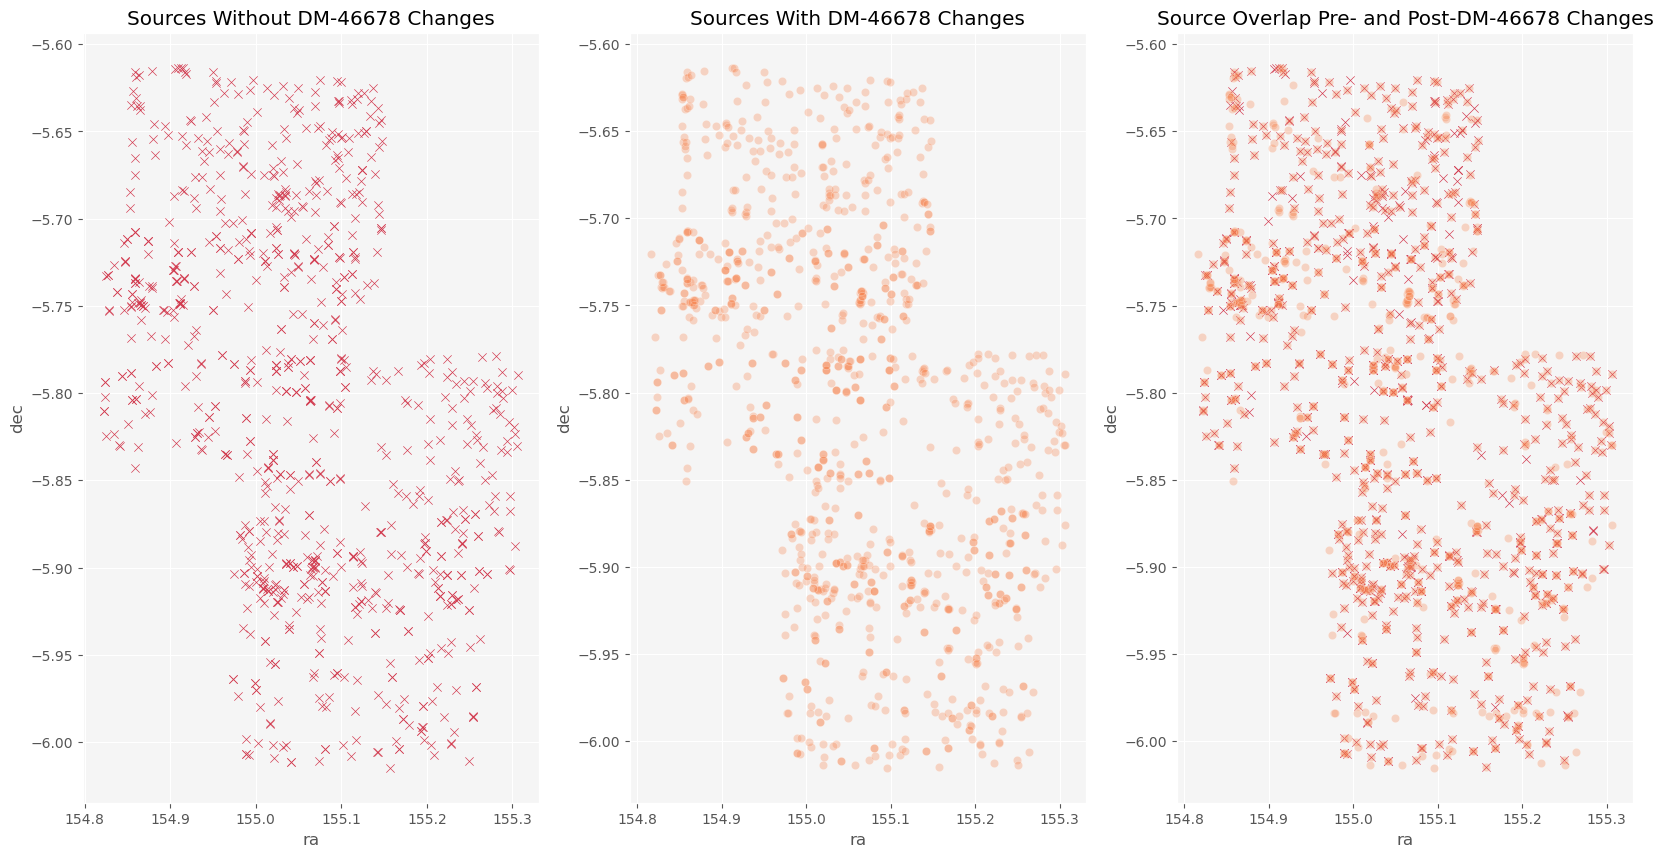

In [14]:
# Full catalogs from Sources With and Without DM-46678 Changes
f, axes = plt.subplots(1, 3, figsize=(20,10))
sns.scatterplot(data=main_run['rsrcTable'], x='ra', y='dec', marker='x', color=sns.color_palette("Spectral", 20)[1], alpha=1.0, ax=axes[0]).set(title=f'Sources Without DM-46678 Changes');
sns.scatterplot(data=dm46678_run['rsrcTable'], x='ra', y='dec', marker='o', color=sns.color_palette("Spectral", 20)[4], alpha=0.3, ax=axes[1]).set(title=f'Sources With DM-46678 Changes');
sns.scatterplot(data=main_run['rsrcTable'], x='ra', y='dec', marker='x', color=sns.color_palette("Spectral", 20)[1], alpha=1.0, ax=axes[2]).set(title=f'Source Overlap Pre- and Post-DM-46678 Changes');
sns.scatterplot(data=dm46678_run['rsrcTable'], x='ra', y='dec', marker='o', color=sns.color_palette("Spectral", 20)[4], alpha=0.3, ax=axes[2]);


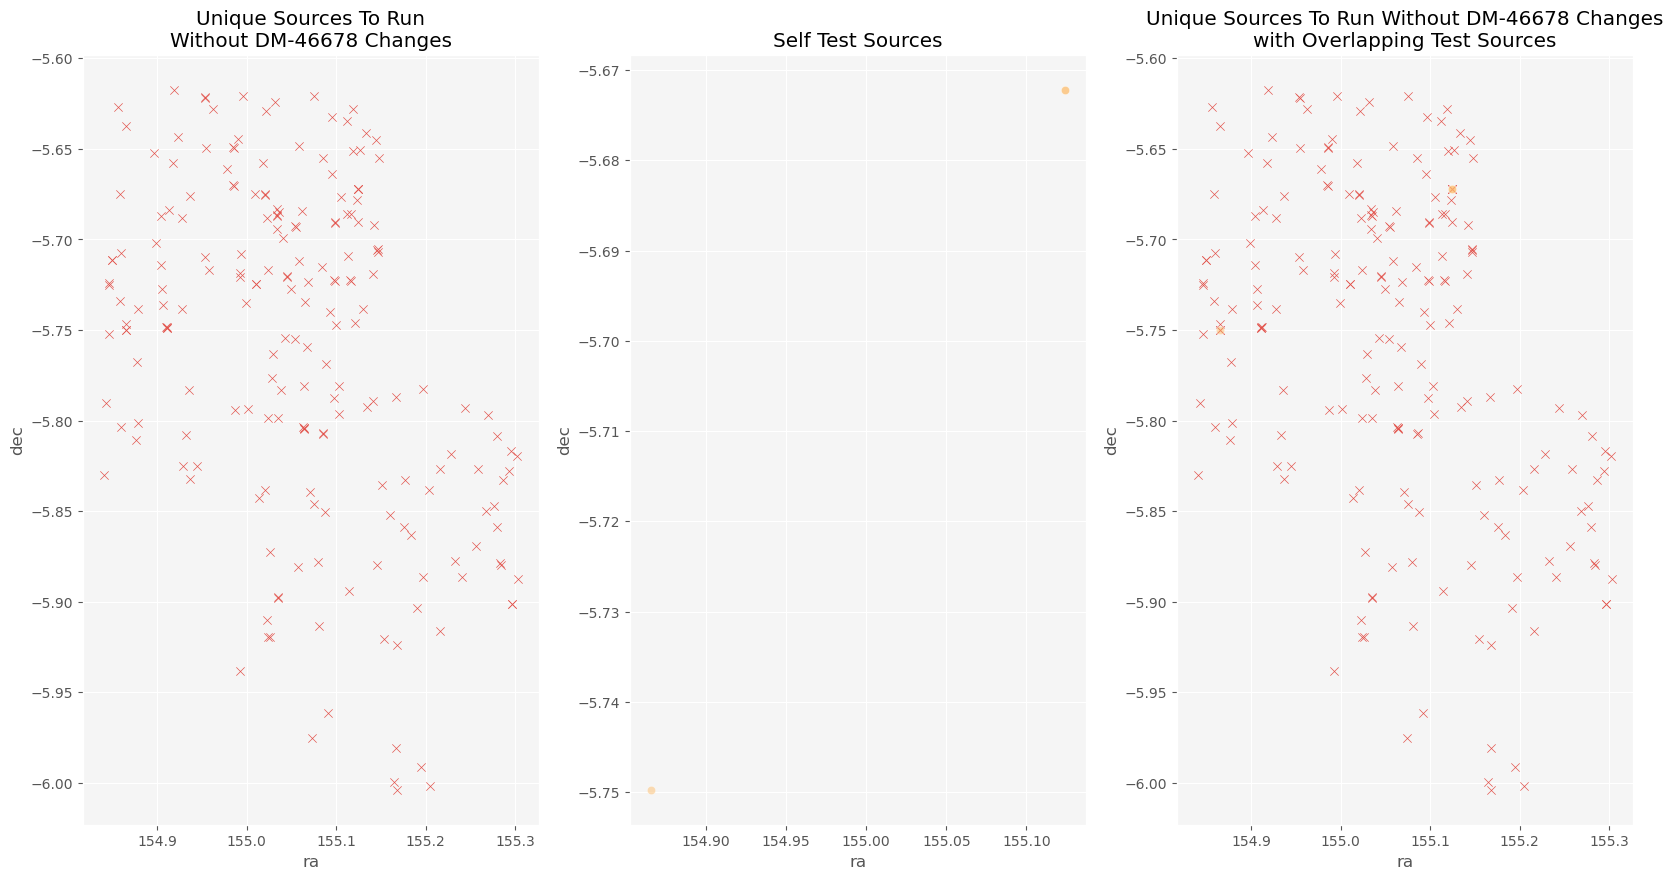

In [15]:
# Unique Sources Without DM-46678 Changes
f, axes = plt.subplots(1, 3, figsize=(20,10))
sns.scatterplot(data=uniqueMain, x='ra', y='dec', marker='x', color=sns.color_palette("Spectral", 20)[2], alpha=1.0, ax=axes[0]).set(title=f'Unique Sources To Run\nWithout DM-46678 Changes');
sns.scatterplot(data=selfTest2, x='ra', y='dec', marker='o', color=sns.color_palette("Spectral", 20)[6], alpha=0.5, ax=axes[1]).set(title=f'Self Test Sources');
sns.scatterplot(data=uniqueMain, x='ra', y='dec', marker='x', color=sns.color_palette("Spectral", 20)[2], alpha=1.0, ax=axes[2]).set(title=f'Unique Sources To Run Without DM-46678 Changes\nwith Overlapping Test Sources');
sns.scatterplot(data=selfTest2, x='ra', y='dec', marker='o', color=sns.color_palette("Spectral", 20)[6], alpha=0.5, ax=axes[2]);

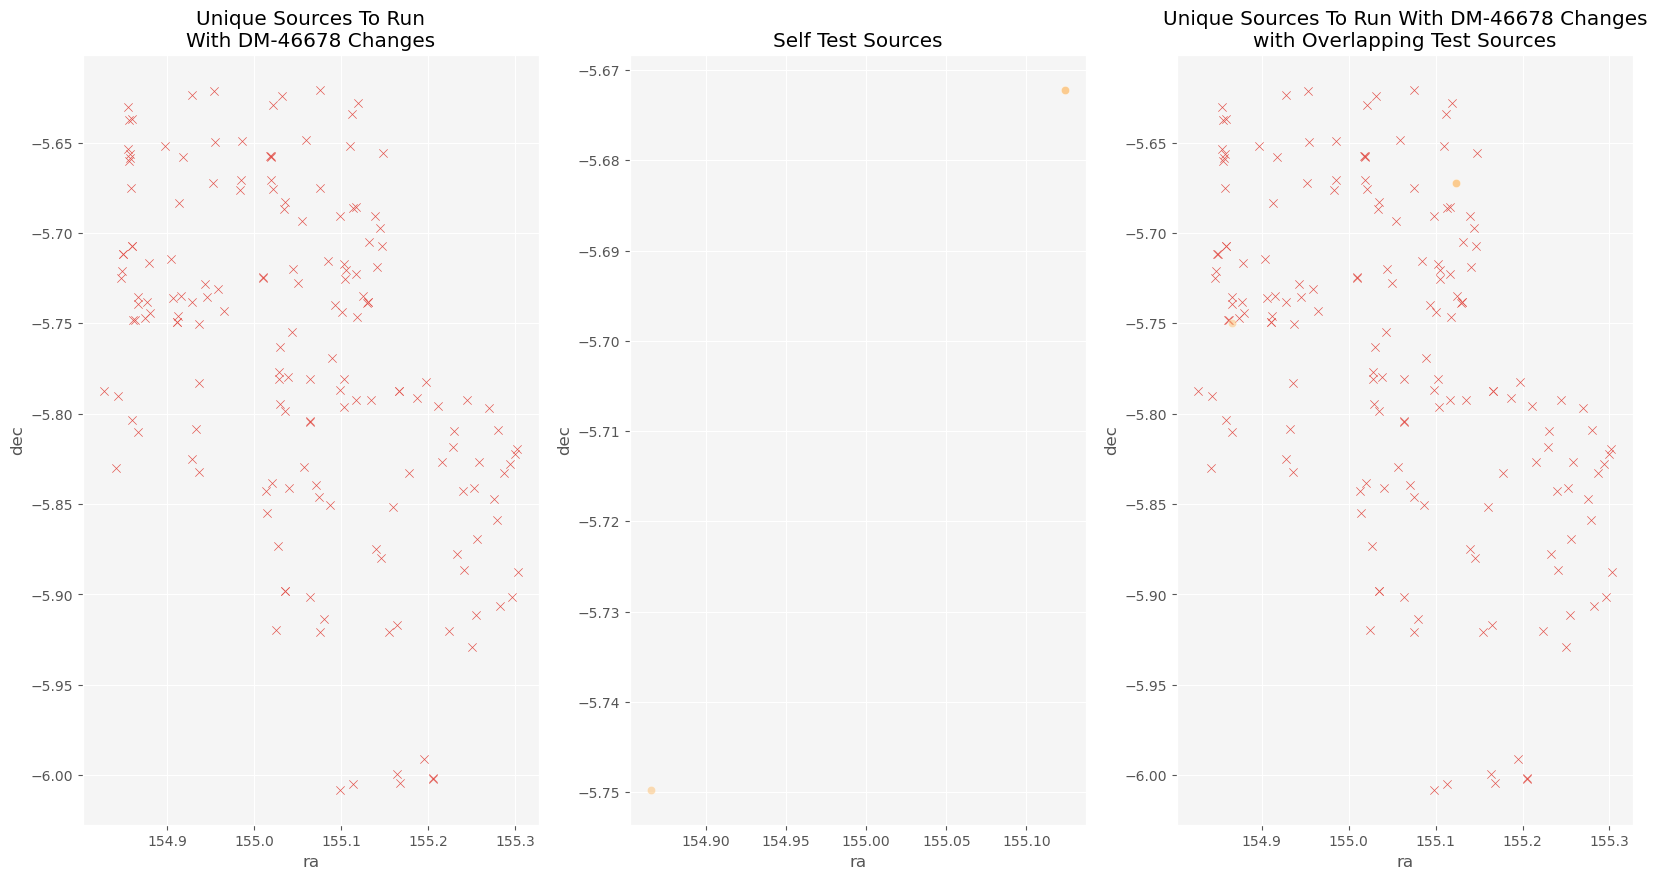

In [16]:
# Unique Sources With DM-46678 Changes + Test Sources
f, axes = plt.subplots(1, 3, figsize=(20,10))
sns.scatterplot(data=unique_dm46678, x='ra', y='dec', marker='x', color=sns.color_palette("Spectral", 20)[2], alpha=1.0, ax=axes[0]).set(title=f'Unique Sources To Run\nWith DM-46678 Changes');
sns.scatterplot(data=selfTest2, x='ra', y='dec', marker='o', color=sns.color_palette("Spectral", 20)[6], alpha=0.5, ax=axes[1]).set(title=f'Self Test Sources');
sns.scatterplot(data=unique_dm46678, x='ra', y='dec', marker='x', color=sns.color_palette("Spectral", 20)[2], alpha=1.0, ax=axes[2]).set(title=f'Unique Sources To Run With DM-46678 Changes\nwith Overlapping Test Sources');
sns.scatterplot(data=selfTest2, x='ra', y='dec', marker='o', color=sns.color_palette("Spectral", 20)[6], alpha=0.5, ax=axes[2]);

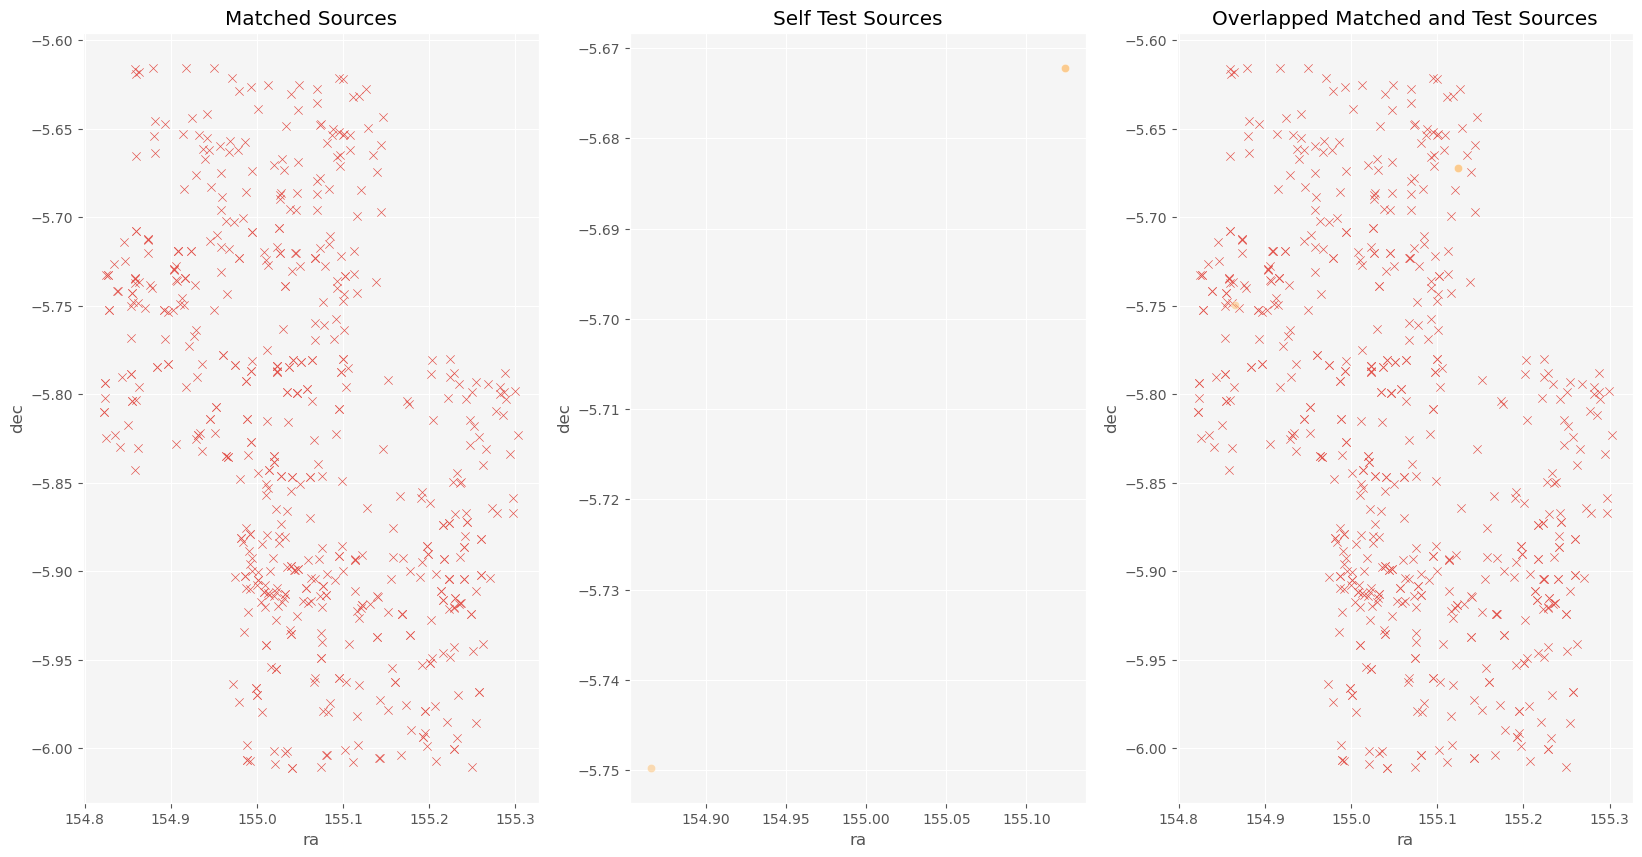

In [17]:
# Matched Sources (With & Without DM-46678 Changes) + Test Sources
f, axes = plt.subplots(1, 3, figsize=(20,10))
sns.scatterplot(data=matched, x='ra', y='dec', marker='x', color=sns.color_palette("Spectral", 20)[2], alpha=1.0, ax=axes[0]).set(title=f'Matched Sources');
sns.scatterplot(data=selfTest2, x='ra', y='dec', marker='o', color=sns.color_palette("Spectral", 20)[6], alpha=0.5, ax=axes[1]).set(title=f'Self Test Sources');
sns.scatterplot(data=matched, x='ra', y='dec', marker='x', color=sns.color_palette("Spectral", 20)[2], alpha=1.0, ax=axes[2]).set(title=f'Overlapped Matched and Test Sources');
sns.scatterplot(data=selfTest2, x='ra', y='dec', marker='o', color=sns.color_palette("Spectral", 20)[6], alpha=0.5, ax=axes[2]);

### 5. Source Comparison at Detector-Level

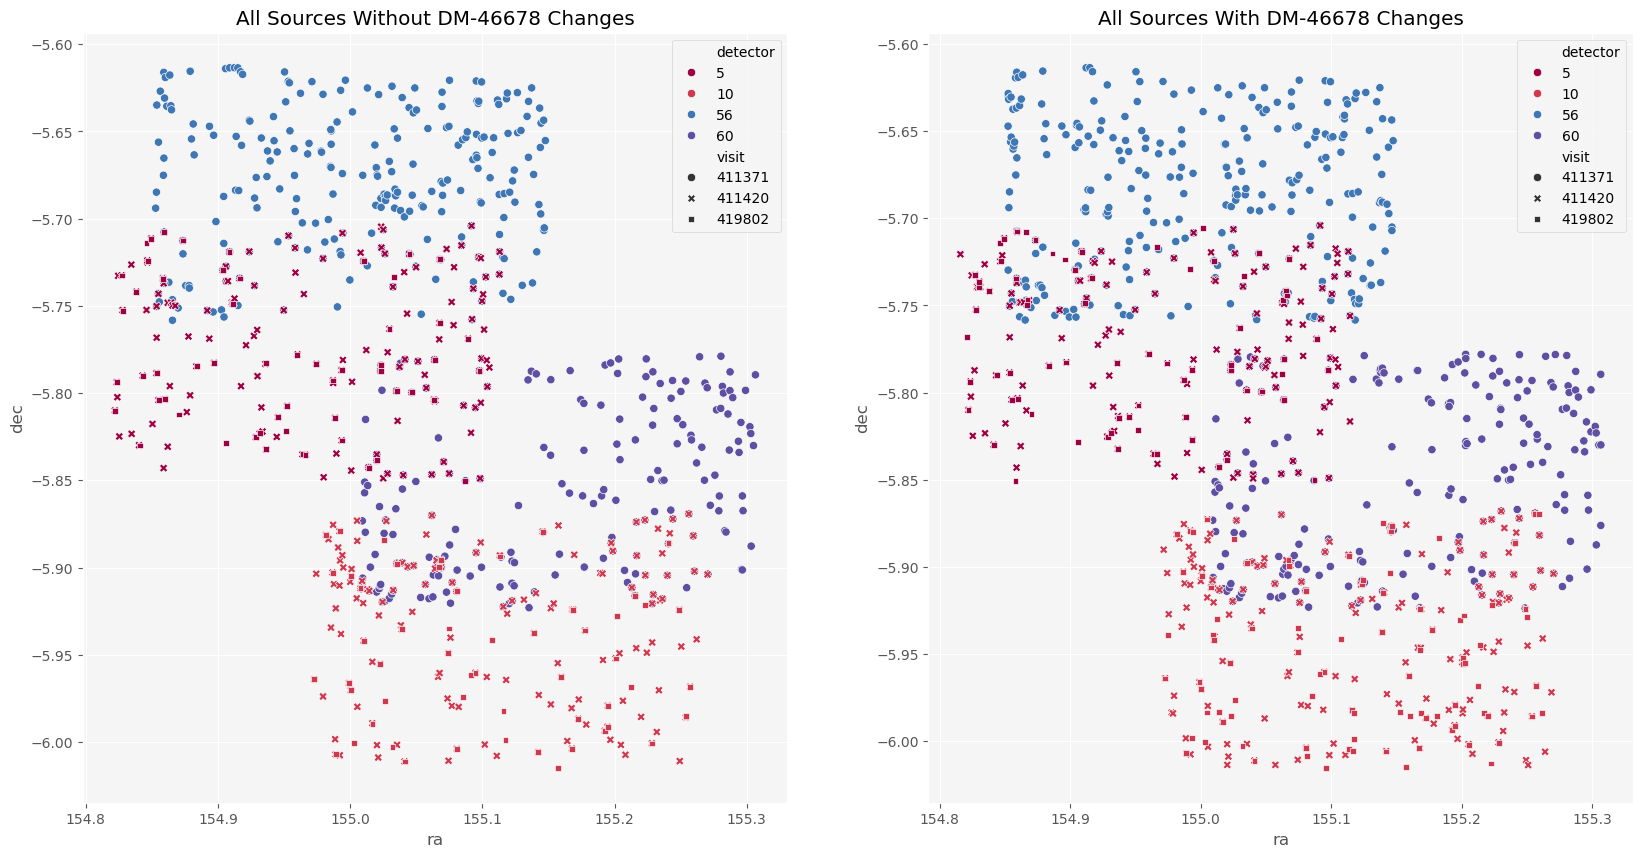

In [18]:
f, axes = plt.subplots(1, 2, figsize=(20,10))
sns.scatterplot(data=main_run['rsrcTable'], x='ra', y='dec', hue='detector', style='visit', palette=sns.color_palette("Spectral", as_cmap=True), alpha=1.0, ax=axes[0]).set(title=f'All Sources Without DM-46678 Changes');
sns.scatterplot(data=dm46678_run['rsrcTable'], x='ra', y='dec', hue='detector', style='visit', palette=sns.color_palette("Spectral", as_cmap=True), alpha=1.0, ax=axes[1]).set(title=f'All Sources With DM-46678 Changes');

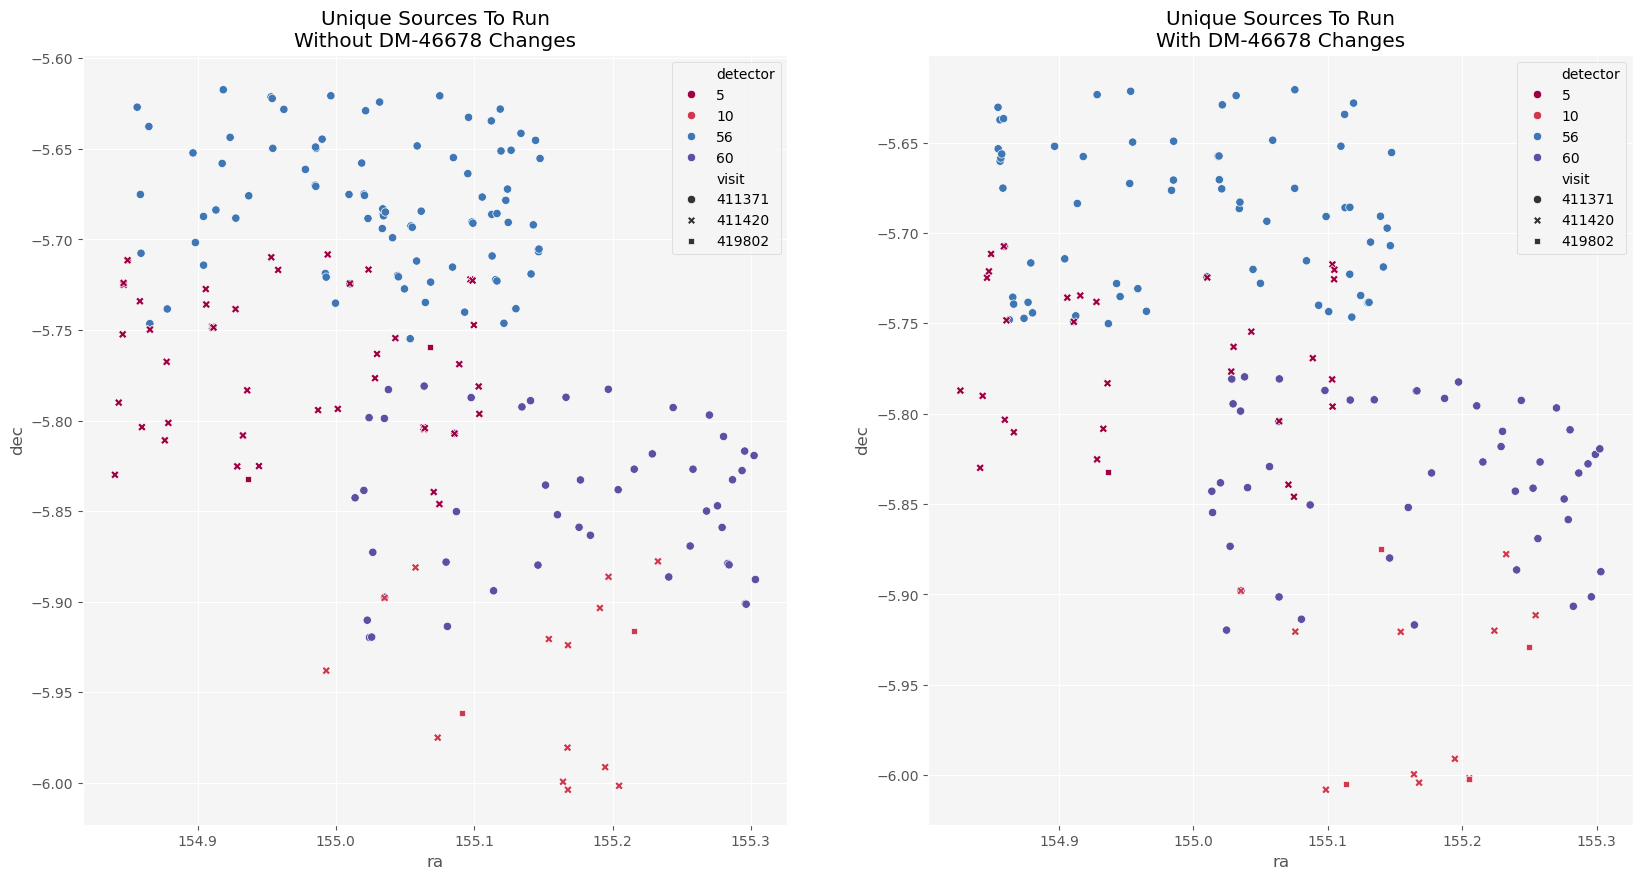

In [19]:
f, axes = plt.subplots(1, 2, figsize=(20,10))
sns.scatterplot(data=uniqueMain, x='ra', y='dec', hue='detector', style='visit', palette=sns.color_palette("Spectral", as_cmap=True), alpha=1.0, ax=axes[0]).set(title=f'Unique Sources To Run\nWithout DM-46678 Changes');
sns.scatterplot(data=unique_dm46678, x='ra', y='dec', hue='detector', style='visit', palette=sns.color_palette("Spectral", as_cmap=True), alpha=1.0, ax=axes[1]).set(title=f'Unique Sources To Run\nWith DM-46678 Changes');

In [20]:
def sourceCompByDetector(main, comparison, mainTitle, updatedTitle):
    sourceNumber_main = []
    sourceNumber_updated = []
    for v, d in zip(visitsAndDetectors['visits'], visitsAndDetectors['detectors']):
        f, axes = plt.subplots(1, 3, figsize=(20,10))
        constrainedMain = main[(main['visit'] == v) & (main['detector'] == d)]
        constrainedUpdated = comparison[(comparison['visit'] == v) & (comparison['detector'] == d)]

        sourceNumber_main.append(len(constrainedMain))
        sourceNumber_updated.append(len(constrainedUpdated))
        
        sns.scatterplot(data=constrainedMain, x='ra', y='dec', marker='x', color=sns.color_palette("Spectral", 20)[1], alpha=1.0, ax=axes[0]).set(title=f'{mainTitle} ({len(constrainedMain)}):\nVisit {v}, Detector {d}');
        sns.scatterplot(data=constrainedUpdated, x='ra', y='dec', marker='o', color=sns.color_palette("Spectral", 20)[4], alpha=0.3, ax=axes[1]).set(title=f'{updatedTitle} ({len(constrainedUpdated)}):\nVisit {v}, Detector {d}');
        sns.scatterplot(data=constrainedMain, x='ra', y='dec', marker='x', color=sns.color_palette("Spectral", 20)[1], alpha=1.0, ax=axes[2]).set(title=f'DM-46678 Changes—Overlapping sources:\nVisit {v}, Detector {d}\n(With/Without) Ratio: {len(constrainedUpdated)/len(constrainedMain):.2f}');
        sns.scatterplot(data=constrainedUpdated, x='ra', y='dec', marker='o', color=sns.color_palette("Spectral", 20)[4], alpha=0.3, ax=axes[2]);

    results = pd.DataFrame({'Visit': visitsAndDetectors['visits'],'Detector': visitsAndDetectors['detectors'],
                            f'Number of Sources {mainTitle}':sourceNumber_main, f'Number of Sources {updatedTitle}':sourceNumber_updated})
    return results


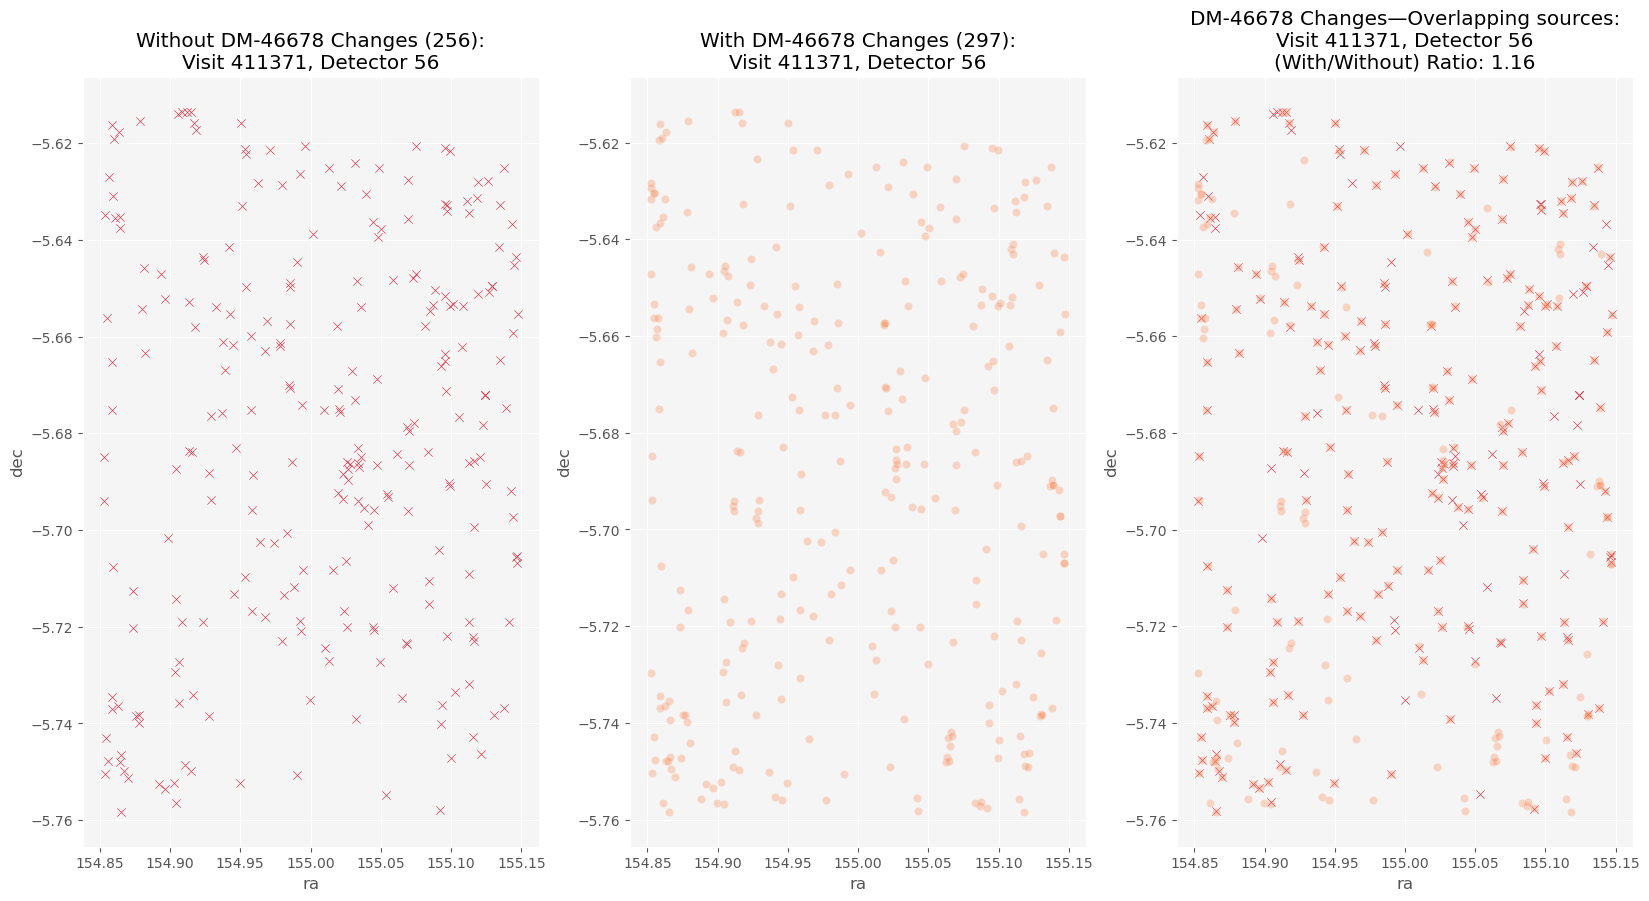

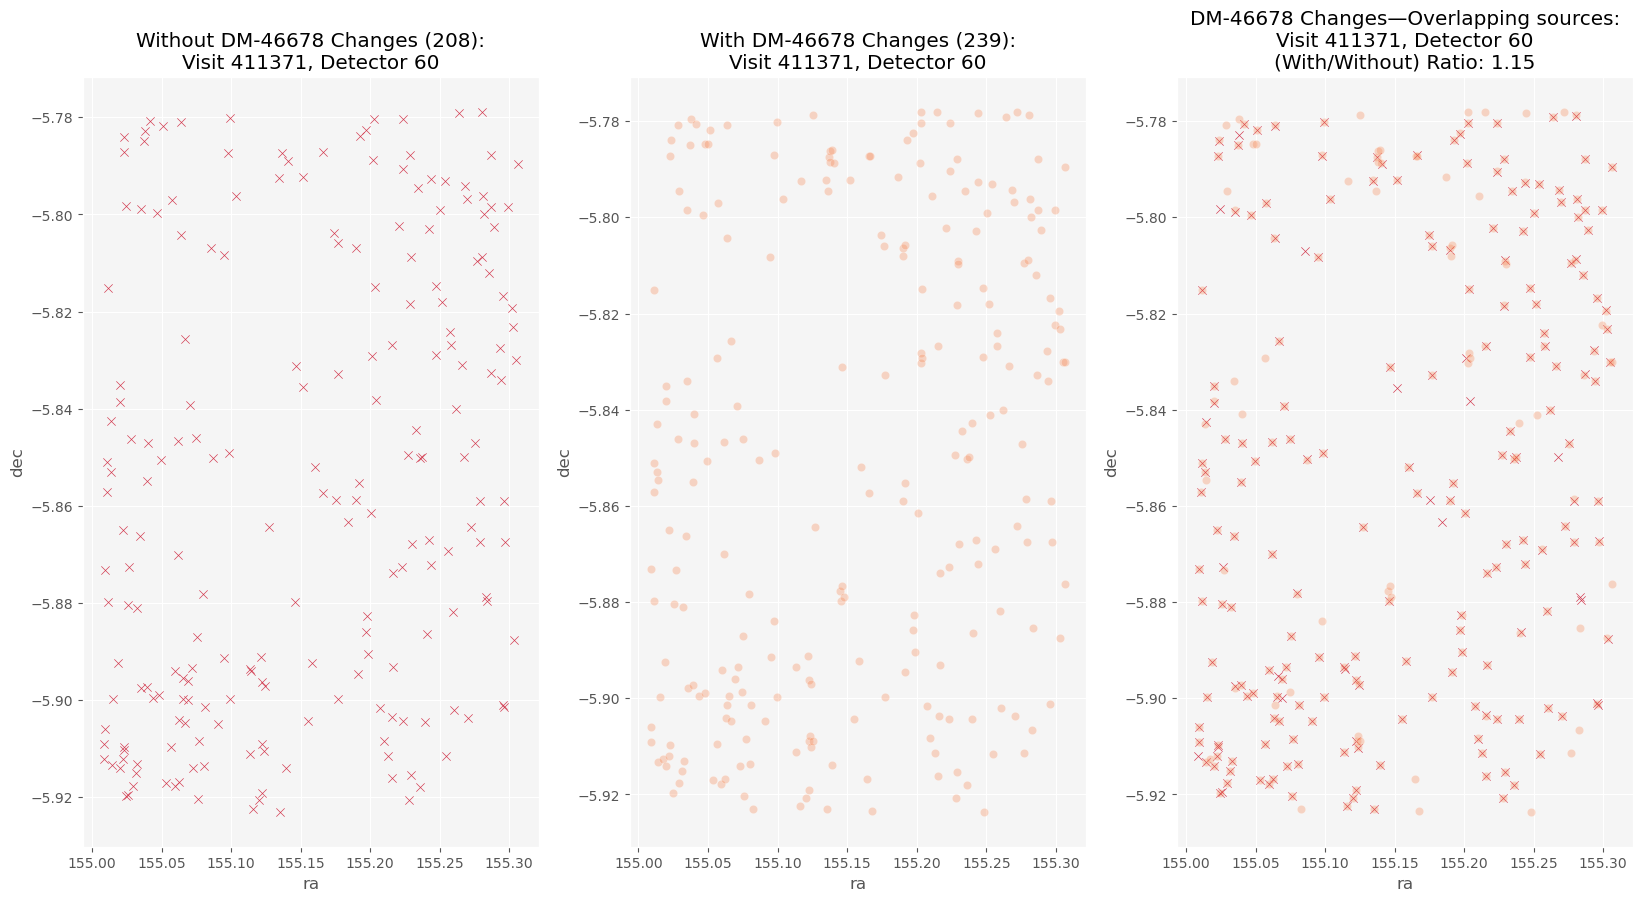

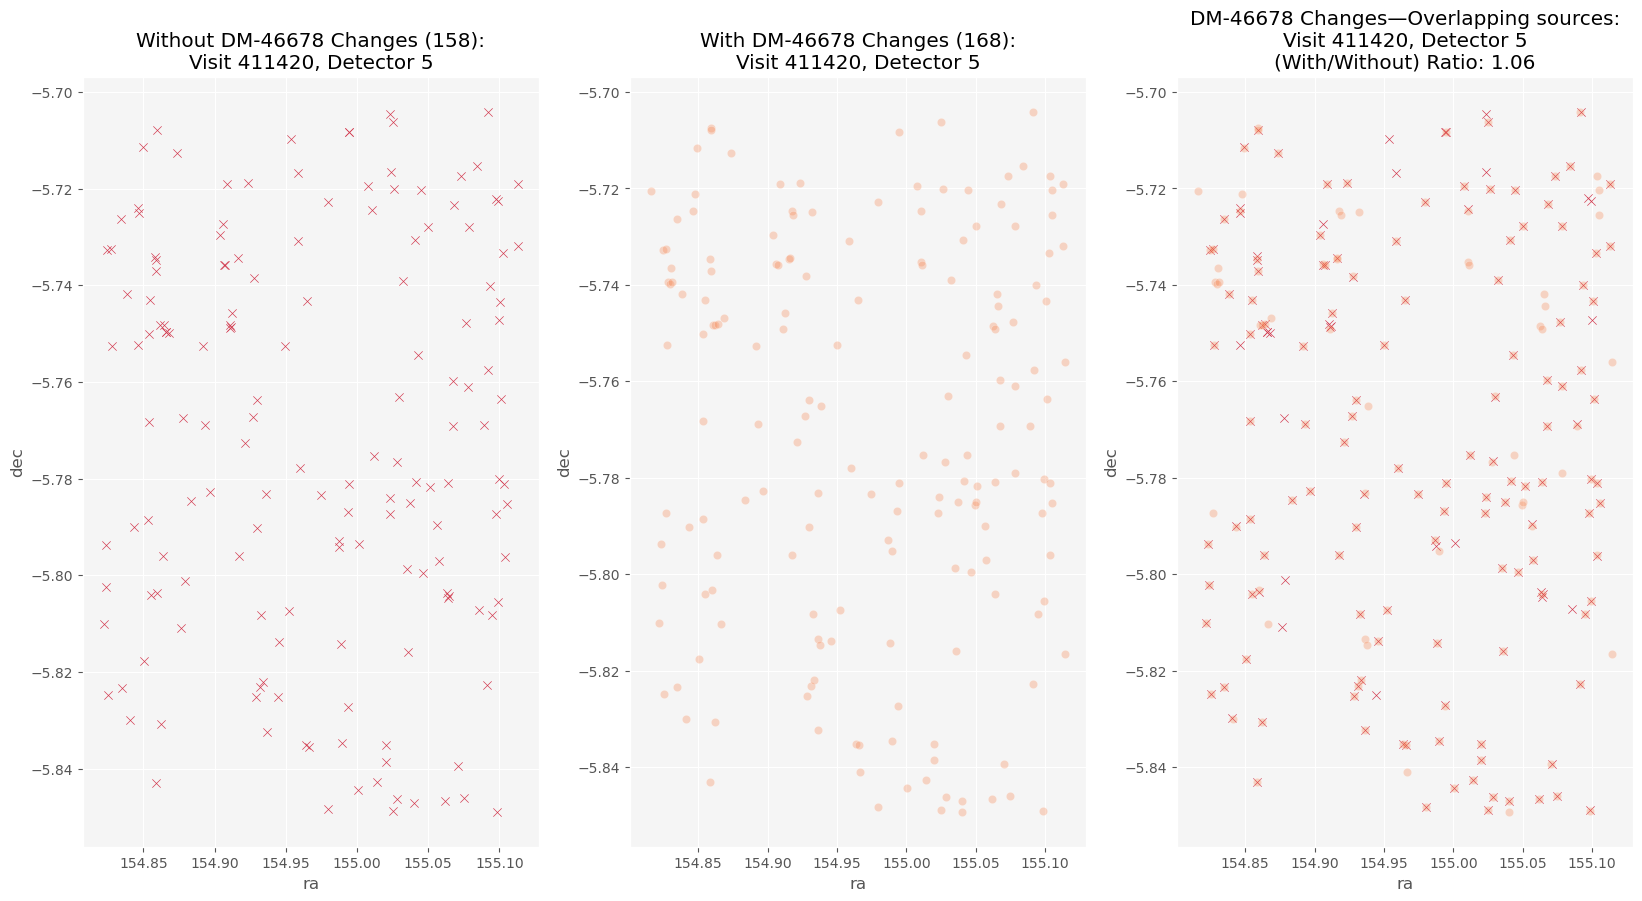

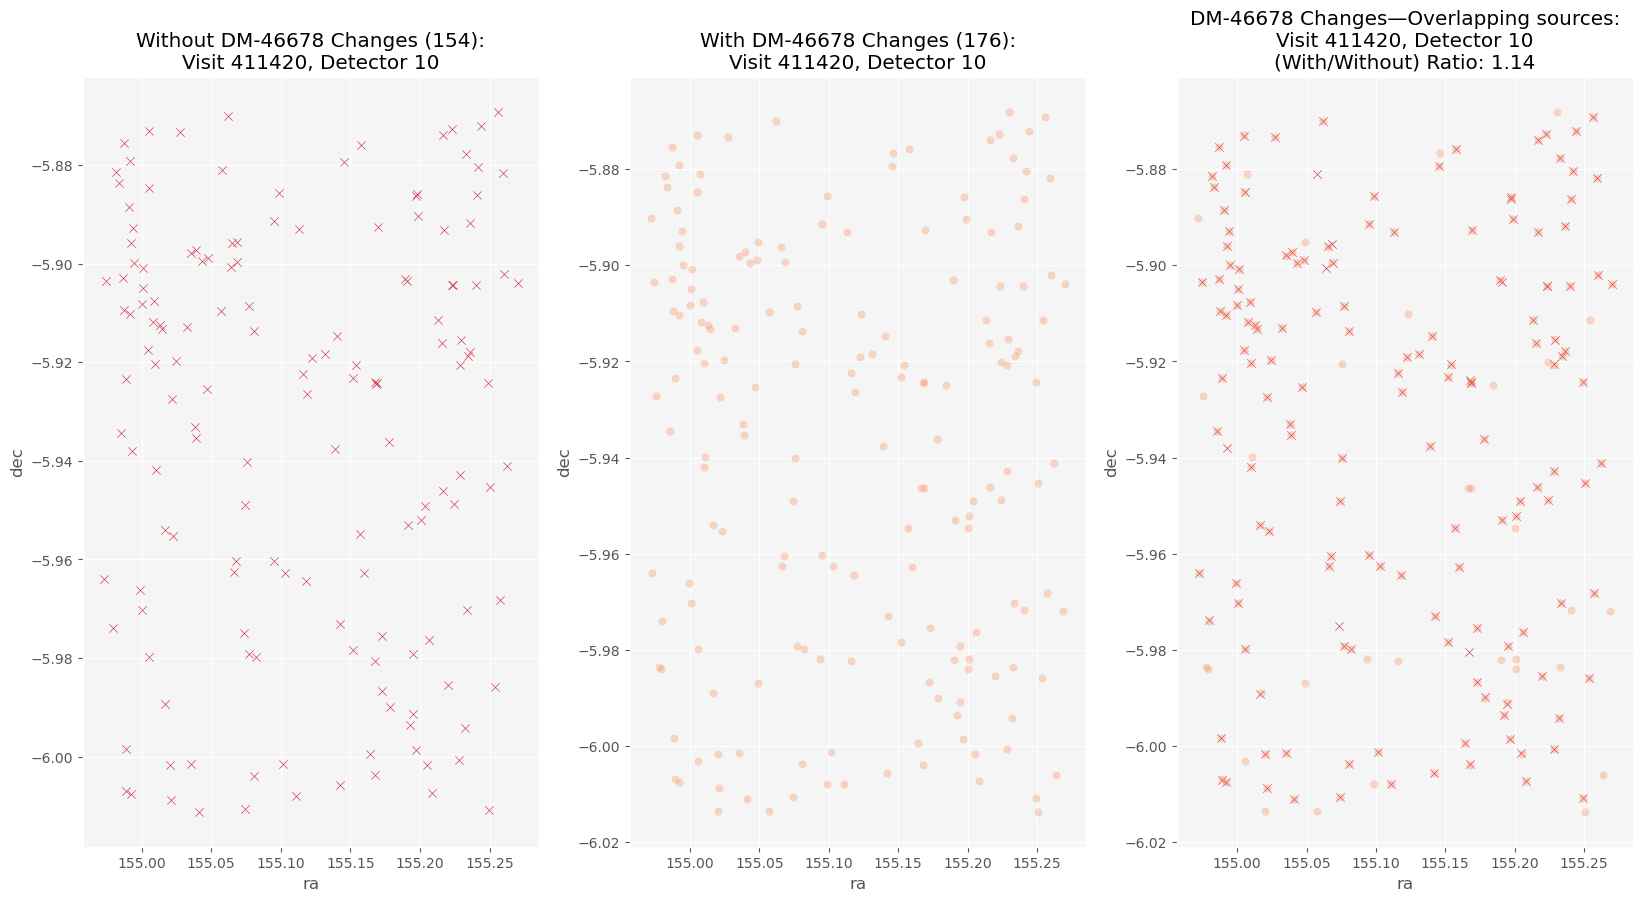

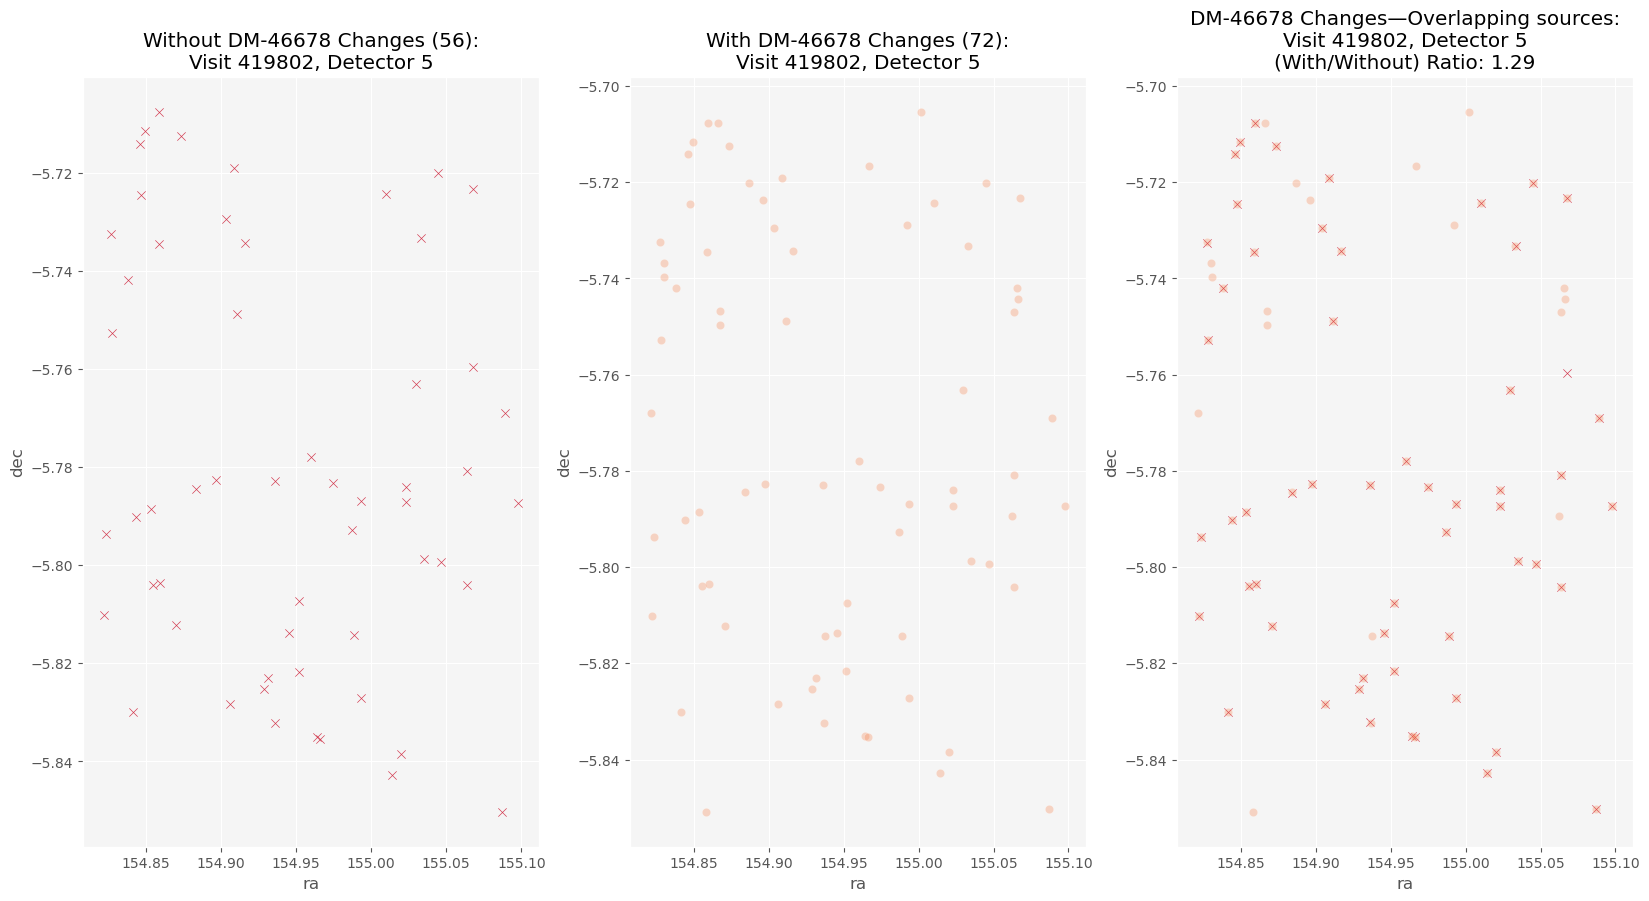

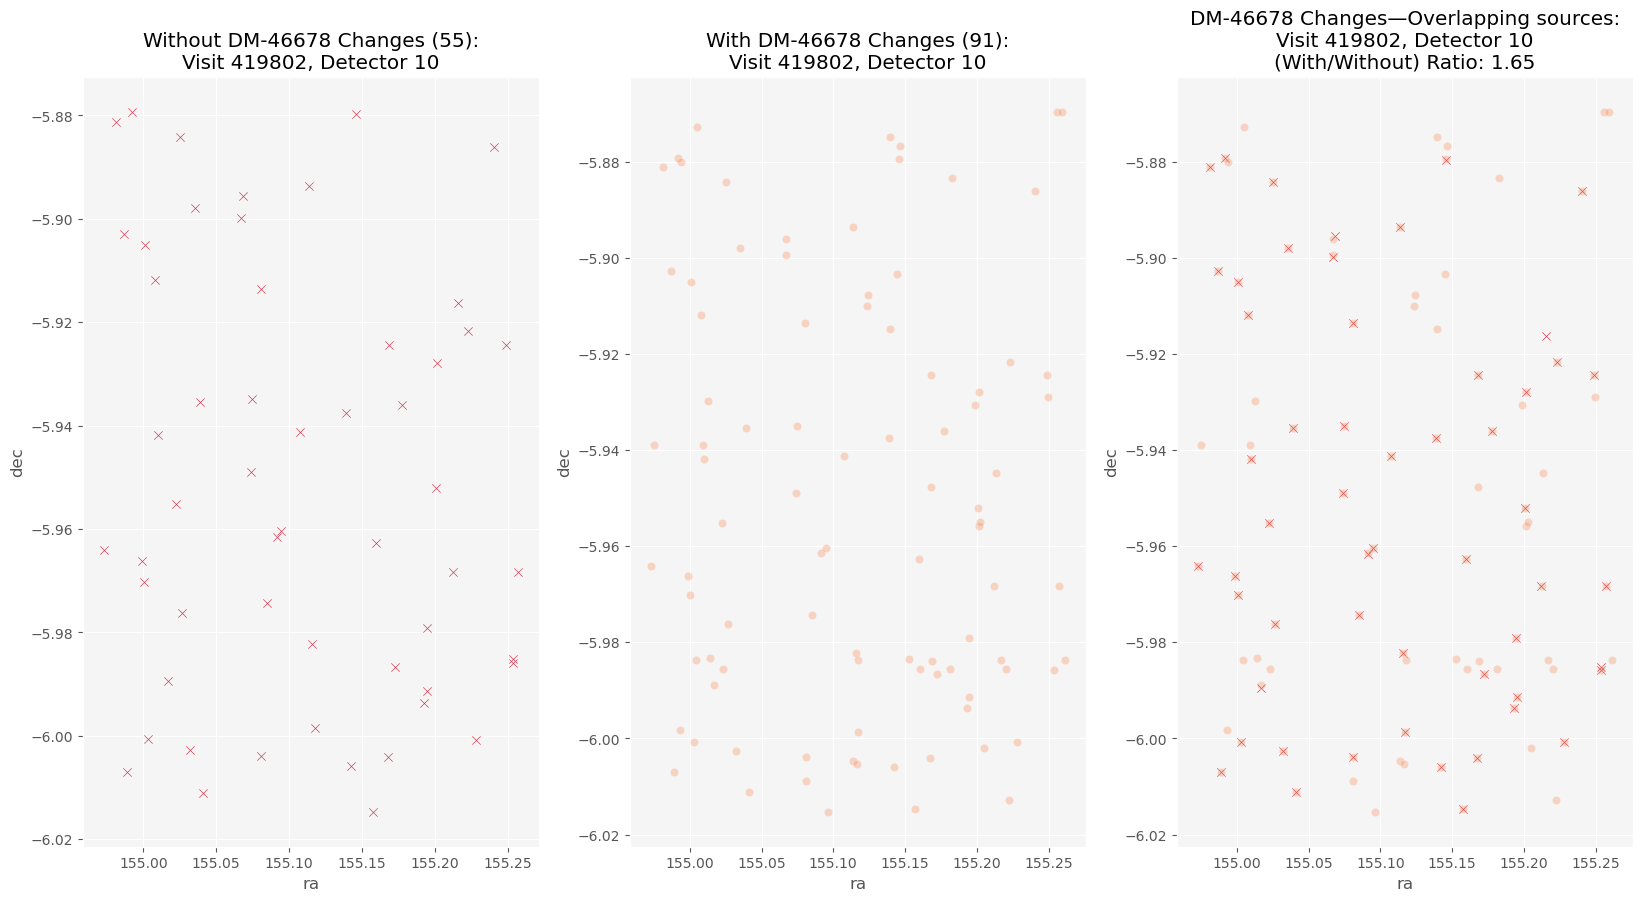

In [21]:
sourceNbyDetector = sourceCompByDetector(main_run['rsrcTable'], dm46678_run['rsrcTable'], 'Without DM-46678 Changes', 'With DM-46678 Changes')

In [22]:
sourceNbyDetector

,Visit,Detector,Number of Sources Without DM-46678 Changes,Number of Sources With DM-46678 Changes
1,411371,56,256,297
2,411371,60,208,239
5,411420,5,158,168
4,411420,10,154,176
0,419802,5,56,72
3,419802,10,55,91


### 6. Plot of fluxes for data with and without DM-46678 changes

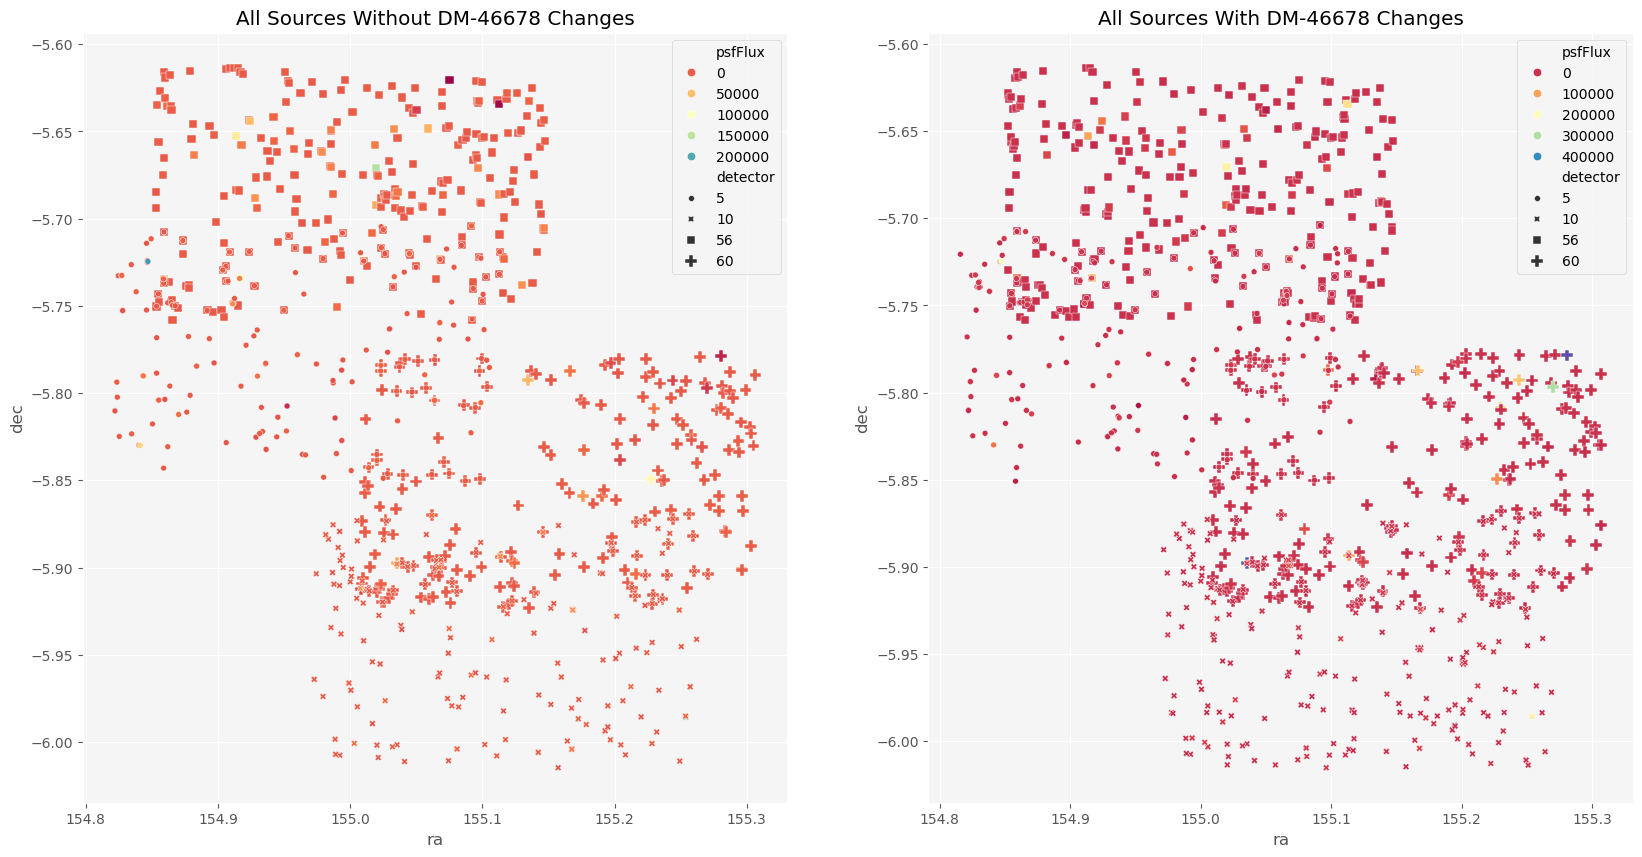

In [23]:
f, axes = plt.subplots(1, 2, figsize=(20,10))
sns.scatterplot(data=main_run['rsrcTable'], x='ra', y='dec', hue='psfFlux', size='detector', style='detector', palette=sns.color_palette("Spectral", as_cmap=True), alpha=1.0, ax=axes[0]).set(title=f'All Sources Without DM-46678 Changes');
sns.scatterplot(data=dm46678_run['rsrcTable'], x='ra', y='dec', hue='psfFlux', size='detector', style='detector', palette=sns.color_palette("Spectral", as_cmap=True), alpha=1.0, ax=axes[1]).set(title=f'All Sources With DM-46678 Changes');

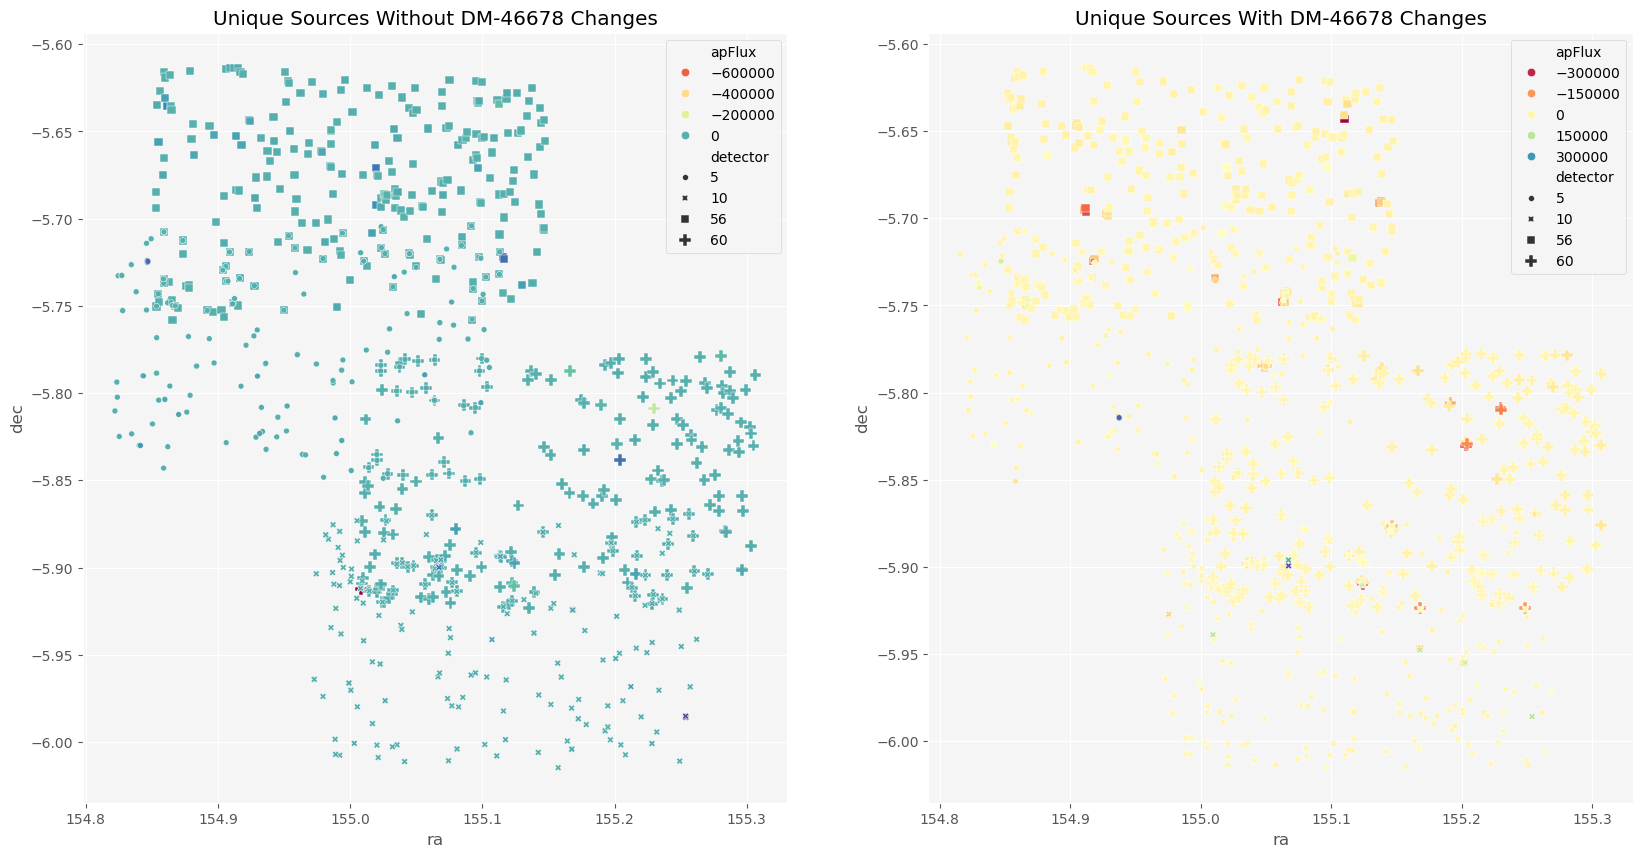

In [24]:
f, axes = plt.subplots(1, 2, figsize=(20,10))
sns.scatterplot(data=main_run['rsrcTable'], x='ra', y='dec', hue='apFlux', size='detector', style='detector', palette=sns.color_palette("Spectral", as_cmap=True), alpha=1.0, ax=axes[0]).set(title=f'Unique Sources Without DM-46678 Changes');
sns.scatterplot(data=dm46678_run['rsrcTable'], x='ra', y='dec', hue='apFlux', size='detector', style='detector', palette=sns.color_palette("Spectral", as_cmap=True), alpha=1.0, ax=axes[1]).set(title=f'Unique Sources With DM-46678 Changes');